# Machine learning

## Overview

* Caution: Field is riddled with buzzwords
  * Machine learning, artificial intelligence, deep learning, belief networks, attention-based networks, long short-term memory, features, hyperparameters ...
  * Anthropomorphized and technical names hide what are usually basic mathematical algorithms

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.toysense.ca%2Fcomponents%2Fcom_virtuemart%2Fshop_image%2Fproduct%2Ffull%2Fspin_prod_85232641259a4676049cd1_r1.jpg&f=1&nofb=1&ipt=2fbb01f01e582ac217911a1cba8785cce7fa9b55533e1e368b62e7e94f233cca&ipo=images" width=20%\>

* Collection of multivariate statistical methods for classification and regression
  * *Multivariate*: item described by more than one variable, e.g. (x, y, z)
  * *Statistical*: something with probability
  * *Classification*: sort sample of points into categories
  * *Regression*: fancy speak for fitting a model to data

* Why do we need this?
  * Humans good at working with 1D or 2D data, because we can visualize it
  * Humans bad at working with higer-dimensional data
  * Algorithms ("machines") scale well to high-dimensional data

* Notable software
  * Multiple algorithms and utilities
    * [Scikit-Learn](https://scikit-learn.org/stable/index.html)
    * [ROOT TMVA](https://root.cern/manual/tmva)
  * Gradient-boosted decision trees (aka gradient boosting machine)
    * [XGBoost](https://xgboost.readthedocs.io/en/stable)
    * [LightGBM](https://github.com/microsoft/LightGBM)
    * [CatBoost](https://catboost.ai)
    * ...
  * Neural networks
    * [Tensorflow](https://www.tensorflow.org)
    * [Keras](https://keras.io) (high-level interface to Tensorflow)
    * [PyTorch](https://github.com/pytorch/pytorch)
    * ...

* Excellent resources for autodidactic learning
  * [Scikit-Learn](https://scikit-learn.org/stable/index.html)
  * [Kaggle](https://www.kaggle.com/)

* All methods can do classification and regression and work with any input
* What to use?
  * Structured data (i.e. tables of numbers): Ensembles of decision trees
    * Good results with default settings
    * Can process continuous and categorical input (m/w, red/green/blue, ...)
    * No data preprocessing required
    * Compute feature importance
  * Unstructured data (i.e. images, waveforms, text...): Neural networks
    * Deep networks learn to extract features automatically
    * Requires data preprocessing
    * Networks difficult to optimize for non-experts
    * Often need very large data sets for training

Some definitions
* *sample*: one or more numbers which describe outcome of stochastic process
* *dataset* consists of *samples*
* *features*: subset of numbers from each sample which carry interesting information, also numbers computed from each sample
* *signal*: samples which originate from stochastic process of interest, typically particle decay
* *background*: samples which do not originate from process of interest

*Discuss how the typical decay $K^0_S \to \pi^+ \pi^-$ is reconstructed and why in general there is always some background*.

*Clarify how the previous terms would be used in the context of this example.*

## Classification

* Setting: dataset is mix of two or more components, typically signal + one or more backgrounds
* Want only signal component, invert a cut to select signal candidates
* Features are variables which allow to discriminate between signal and background, for example, reconstructed mass of decay candidate

In [55]:
#!pip install scipy matplotlib numpy scikit-learn xgboost

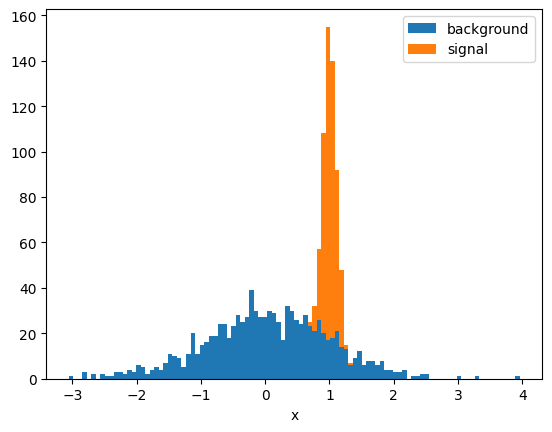

In [56]:
from scipy.stats import norm
from matplotlib import pyplot as plt
import numpy as np

background = norm(0, 1).rvs(1000, random_state=1)
signal = norm(1, 0.1).rvs(500, random_state=1)

x = np.append(signal, background)
y = np.append(np.ones(len(signal)), np.zeros(len(background)))

def plot(x, y):
    signal = x[y == 1]
    background = x[y == 0]
    t, xe = np.histogram(x, bins=100)
    s = np.histogram(signal, bins=xe)[0]
    b = np.histogram(background, bins=xe)[0]
    plt.stairs(b, xe, fill=True, label="background")
    plt.stairs(t, xe, baseline=b, fill=True, label="signal")
    plt.xlabel("x")
    plt.legend();
    return xe

plot(x, y);

Exercise:
* Propose simple selection ("cut") that keeps most of the signal and removes most of the background
* Is it possible to eliminate the background completely?

### Efficiency and purity of a selection

* Efficiency: fraction of signal left after applying selection
  * Number of true signal samples after cut / Number of all true signal samples
* Purity: fraction of background still contained in selected sample
  * Number of true signal samples after cut / Number of selected samples
* Want to maximize efficiency and purity

#### Single-parameter cut

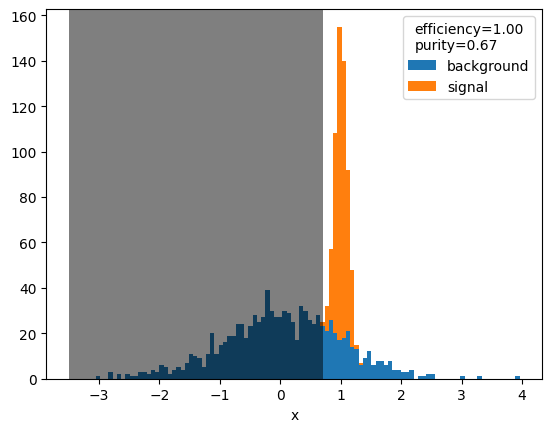

In [57]:
xmin = 0.7

selected_signal = np.sum(x[y==1] > xmin)
total_signal = np.sum(y==1)
selected = np.sum(x > xmin)

efficiency = selected_signal / total_signal
purity = selected_signal / selected

plot(x, y)
plt.axvspan(-3.5, xmin, facecolor="k", alpha=0.5)
plt.legend(title=f"efficiency={efficiency:.2f}\npurity={purity:.2f}");

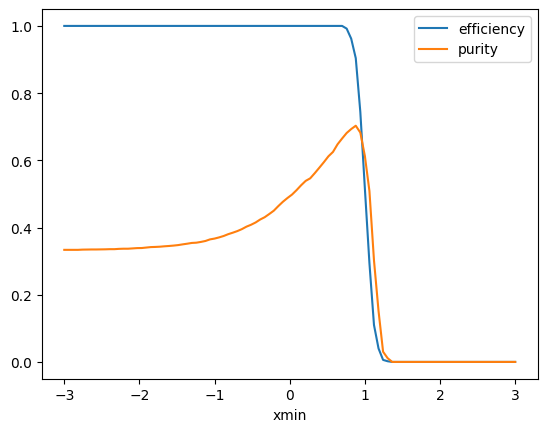

In [58]:
xmin = np.linspace(-3, 3, 100)

efficiency = []
purity = []
for xm in xmin:
    selected_signal = np.sum(signal > xm)
    total_signal = len(signal)
    selected = np.sum(x > xm)
    e = selected_signal / total_signal
    p = selected_signal / selected
    efficiency.append(e)
    purity.append(p)

plt.plot(xmin, efficiency, label="efficiency")
plt.plot(xmin, purity, label="purity")
plt.xlabel("xmin")
plt.legend();

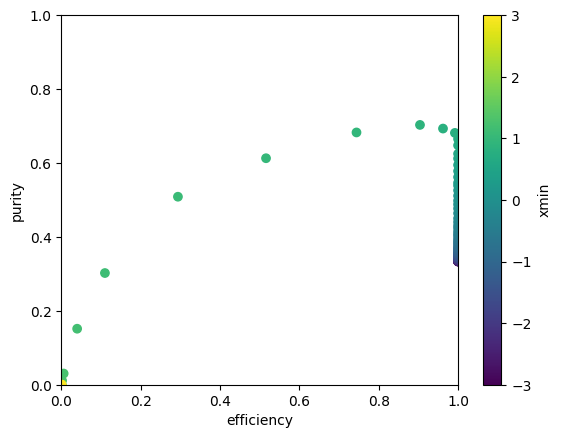

In [59]:
plt.scatter(efficiency, purity, c=xmin);
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("efficiency")
plt.ylabel("purity")
plt.colorbar().set_label("xmin")

In [60]:
arg = np.argmax(purity)
print("efficiency at max purity", efficiency[arg])

efficiency at max purity 0.904


* How to choose cut?
  * Want to maximize efficiency and purity, but what trade-off between the two?
* Often subjective choice is acceptable, because exact answer is difficult
* Objective answer given by figure-of-merit (FOM)
  * Popular is [Punzi FOM](https://inspirehep.net/literature/634798)
  * Most FOM (including Punzi FOM) **only** minimize statistical uncertainty
  * Correct FOM has to minimize total uncertainty = statistical ⊕ systematic
  * Systematic uncertainty often difficult to quantify: fallback to Punzi or subjective choice

#### BDT-based cut

* We can do better with two cuts, on xmin and xmax
* Space of cut parameters then already two-dimensional
* With 2D data
  * Four rectangular cuts possible (4 cut parameters)
  * Infinitely many non-rectangular cuts possible
* Use machine instead, needs to be trained on labeled data

* Use BDT classifier from [XGBoost](https://xgboost.readthedocs.io/en/stable/)
* [Gradient boosting machines regularly win Kaggle competitions](https://www.kaggle.com/code/antgoldbloom/what-algorithms-are-most-successful-on-kaggle?scriptVersionId=0)
* Well documented, fast, parallizable, tunable

In [61]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split

# generate training data, ideally we have more than actual data
background = norm(0, 1).rvs(100000, random_state=2)
signal = norm(1, 0.1).rvs(50000, random_state=2)
x2 = np.append(signal, background)

# features in general matrix [N, K] for N samples and K features
X = x2.reshape((len(x2), 1))
# labels: signal=1, background=0
y = np.append(np.ones_like(signal), np.zeros_like(background))

# ALWAYS do this: split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# actual magic happens here
clf = XGBClassifier(random_state=4)
clf.fit(X_train, y_train);

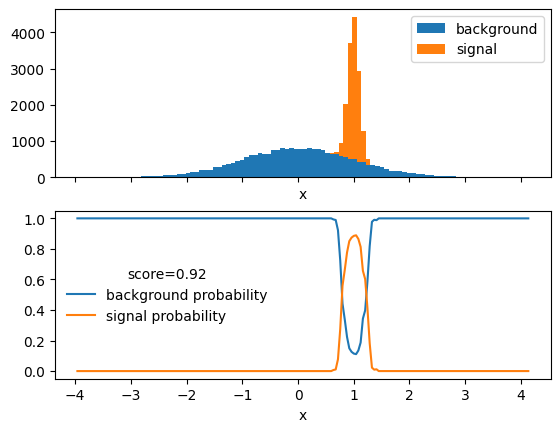

In [62]:
fig, ax = plt.subplots(2, sharex=True)

plt.sca(ax[0])
xe = plot(X_test[:, 0], y_test)

plt.sca(ax[1])
score = clf.score(X_test, y_test)
xm = np.linspace(xe[0], xe[-1], 200)
ps, pb = clf.predict_proba(xm).T

plt.plot(xm, ps, "C0-", label="background probability")
plt.plot(xm, pb, "C1-", label="signal probability")
plt.xlabel("x")
plt.legend(title=f"score={score:.2f}", frameon=False);

Exercise:
* Vary some hyperparameters in `XGBClassifier` to see how score, runtime, and predicted probability changes
  * `n_estimators` try e.g. 2, 5, 10
  * `max_depth` try e.g. 1, 5, 10
  * `learning_rate` try e.g. 0.001, 0.05, 0.5, 1

* BDT predicts signal probability
* We use this to implement our cut: select regions with high signal probability

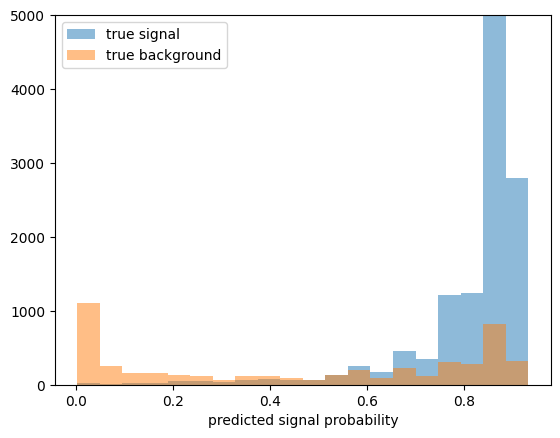

In [63]:
ps = clf.predict_proba(X_test[y_test==1])[:, 1]
pb = clf.predict_proba(X_test[y_test==0])[:, 1]
xe = plt.hist(ps, bins=20, alpha=0.5, label="true signal")[1]
plt.hist(pb, bins=xe, alpha=0.5, label="true background")
plt.legend()
plt.xlabel("predicted signal probability")
plt.ylim(0, 5e3);

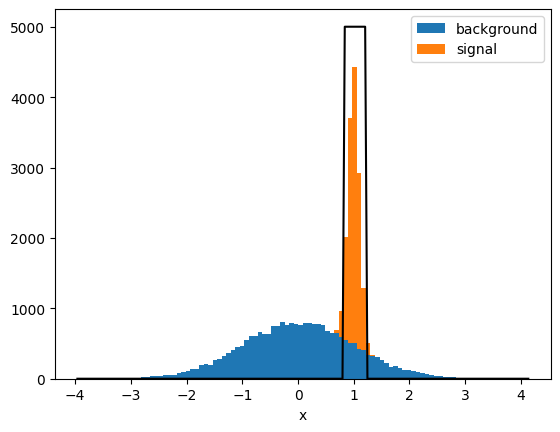

In [64]:
xe = plot(X_test[:, 0], y_test)

# chosen cut: signal probability > 0.6
# visualize accepted region
xm = np.linspace(xe[0], xe[-1], 200)
mask = clf.predict_proba(xm)[:, 1] > 0.6
plt.plot(xm, mask * 5000, "k-");

/var/folders/tl/pv6mt7z17tz0stm1fjfg01cc0000gn/T/ipykernel_88670/1441949194.py:11: RuntimeWarning: invalid value encountered in double_scalars
  p = selected_signal / selected


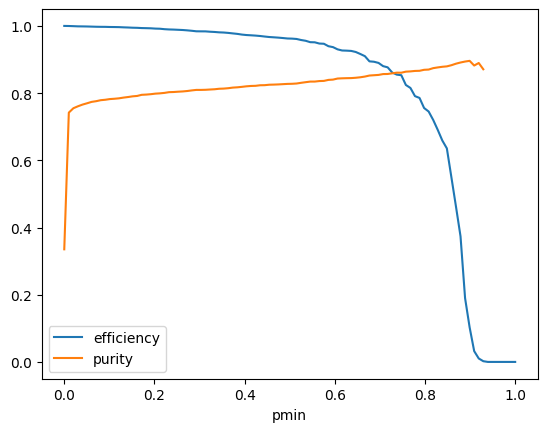

In [65]:
pmin = np.linspace(0, 1, 100)

efficiency = []
purity = []
for pm in pmin:
    mask = clf.predict_proba(X_test)[:, 1] > pm
    selected = np.sum(mask)
    selected_signal = np.sum(y_test[mask])
    total_signal = np.sum(y_test)
    e = selected_signal / total_signal
    p = selected_signal / selected
    efficiency.append(e)
    purity.append(p)

plt.plot(pmin, efficiency, label="efficiency")
plt.plot(pmin, purity, label="purity")
plt.xlabel("pmin")
plt.legend();

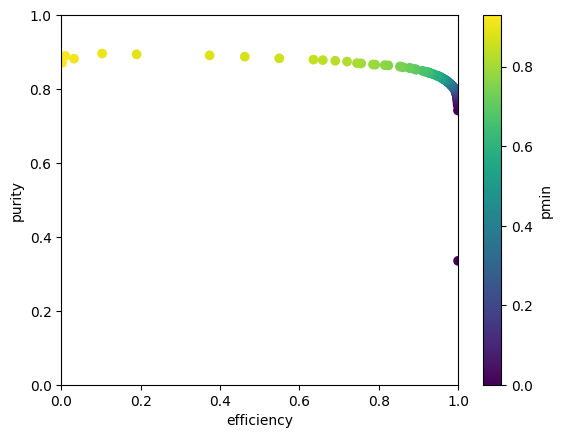

In [66]:
plt.scatter(efficiency, purity, c=pmin);
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("efficiency")
plt.ylabel("purity")
plt.colorbar().set_label("pmin")

* Physicists like efficiency and purity, but ROC curve is standard
* Receiver-operator characteristic
* ROC plots *true positive rate* (fraction of signal that passes cut) over *false positive rate* (fraction of background that passes cut)
* Scikit-Learn provides a quick way to generate this plot

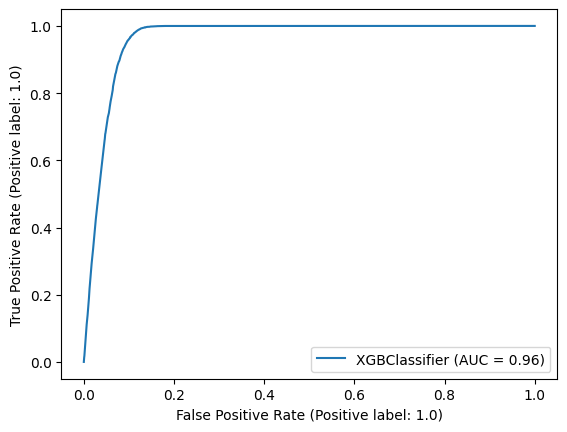

In [67]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test);

* area under curve (AUC) is a common metric to compare the performance of two different classifiers
* we can also use Scikit-Learn to compute ROC points and AUC and plot it ourselves

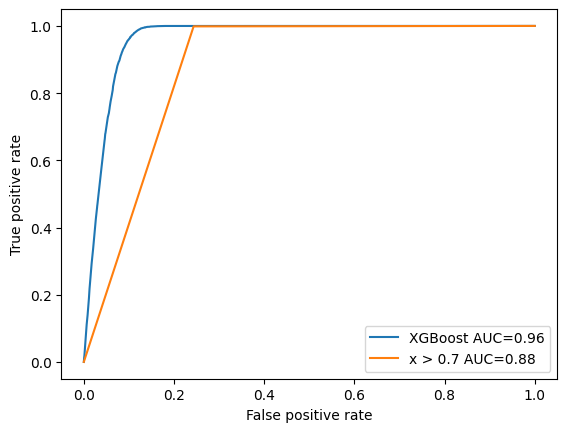

In [68]:
from sklearn.metrics import roc_curve, auc

# plot XGBoost curve again
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"XGBoost AUC={auc(fpr, tpr):.2f}")

# plot ROC curve for our simple x > 0.7 cut for comparison
fpr2, tpr2, _ = roc_curve(y_test, X_test[:, 0] > 0.7)
plt.plot(fpr2, tpr2, label=f"x > 0.7 AUC={auc(fpr2, tpr2):.2f}")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend();

* Exercise: [run scikit-learn example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
* Try adding XGBClassifier into the comparison
* Play around with the hyperparameters of the classifiers

## Regression

* Regression (aka fitting): "learn" function y = f(x) from points(x, y), where both x and y can be vectors
* Machines can do this, but we rarely need this in HEP
* We usually prefer to use theoretically motivated models or hand-crafted low-order polynoms

* Let's try regression on one-dimensional function

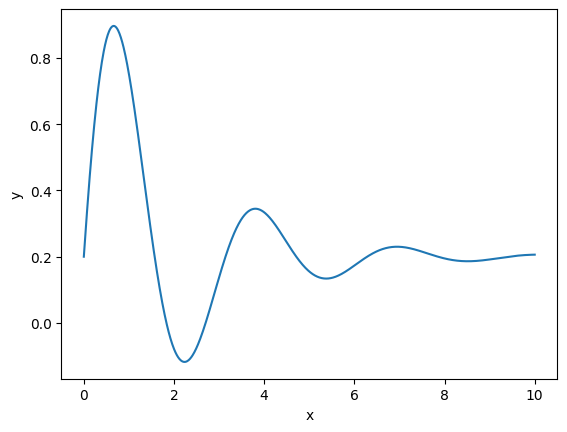

In [69]:
def model(x, a, b, c, d):
    return a + b * np.sin(c * x) * np.exp(- d * x)

truth = 0.2, 1, 2, 0.5

x = np.linspace(0, 10, 1000)
plt.plot(x, model(x, *truth))
plt.xlabel("x")
plt.ylabel("y");

* generate random points on this curve and add some noise to make it more realistic

In [70]:
rng = np.random.default_rng(1)

x = rng.uniform(0, 10, 1000)
y = model(x, 0.2, 1, 2, 0.5)
y += rng.normal(0, 0.05, len(y))

X = np.reshape(x, (-1, 1))

* (X, y) are inputs for regression similar to before, but y is a real number now, not a label (integer)

### Neural network

* We use [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) from Scikit-Learn, a basic neural network
* Neural networks always need preprocessing
* Scikit-Learn offers pipelines to automate this, use them

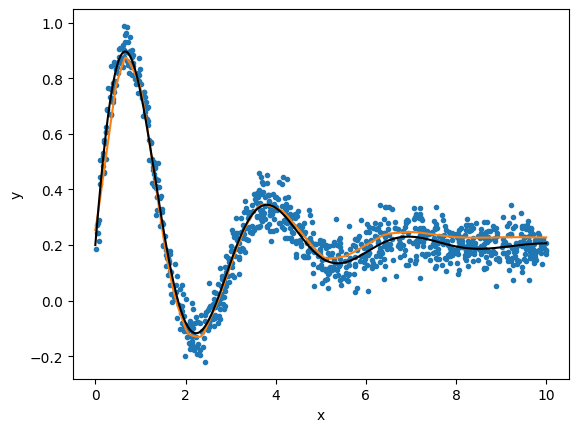

In [71]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.plot(x, y, ".")

# network with 5 layers, each with 100 nodes
regressor = MLPRegressor(
    hidden_layer_sizes=(100,)*5,
    random_state=1)

# we use basic StandardScaler for preprocessing
pipeline = make_pipeline(StandardScaler(), regressor)
pipeline.fit(X, y)

# plot fitted curve
X2 = np.reshape(np.linspace(0, 10, 1000), (-1, 1))
y2 = pipeline.predict(X2)
plt.plot(X2[:, 0], y2, label="Neural net")

plt.plot(X2[:, 0], model(X2[:, 0], *truth), color="k", label="truth")

plt.xlabel("x")
plt.ylabel("y");

* Exercise: play around with hyperparameters of MLPRegressor
* What happens if you remove the StandardScaler?
* What performs better, deep or wide networks?

### Gaussian Process

* For low-dimensional data, Gaussian Process Regression can work well
* Not easy to set up: need to select suitable kernels and configure them
* Advantage: Predicts uncertainty and automatically provides smooth solution

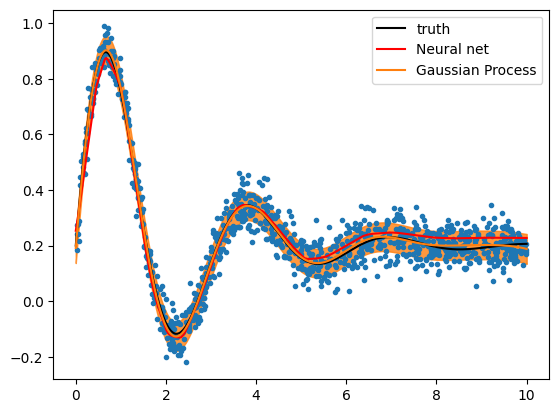

In [72]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = RBF() + WhiteKernel()

gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y)
y3, y3err = gpr.predict(X2, return_std=True)

plt.plot(x, y, ".")
plt.plot(X2[:, 0], model(X2[:, 0], *truth), color="k", label="truth")
plt.plot(X2[:, 0], y2, color="r", label="Neural net")
l = plt.plot(X2[:, 0], y3, label="Gaussian Process")[0]
plt.fill_between(X2[:, 0], y3 - y3err, y3 + y3err, alpha=0.8, color=l.get_color())
plt.legend();